<h1 align="center">STACKOVERFLOW SEARCH ENGINE</H1> 

<h4> Problem </h4>
<p>
build a search engine based on StackOverflow questions, the search results should include the semantic meaning
https://meta.stackexchange.com/questions/138356/how-do-i-download-stack-overflows-data think of scalable 
architecture and try to reduce the time to return the results.
    
<h5> Objectives </h5>
<p>
1) Find top k posts which is more similar or sementically similar to the given query posts
</p>

<h5> Constraints </h5>
1) Low latency  <br>
2) Scalability

<h4> My Approach </h4>
<h5> Data Collection </h5>
<p>
1) The above link contains all stack overflow data among which only the posts.xml files of four topics is downloaded.
namely data science, AI, computer graphics and computer science.Both the posts and meta posts files of all the topics
is downloaded.Hence a total of 9 files is collected for building intial search engine.This is done to create 
a sample simple search engine for all the four topics.
</p>
<p>
2) All the posts.xml files is passed to a xml parser so that only text attribute value of each of the 
posts is retrived as it is the only thing which is relevant to us.
</p>
<p>
3) Each posts.xml file is converted into corresponding .csv file where each row consists only the row id, text of 
the posts and topic of the posts.The topic of the posts is obtained from the filename in which all the posts are 
stored.For Eg., All datascience posts are stored in datascience.xml file.Hence datascience is made as the topic for all the posts in that file
</p>
<p>
4) For all of the 9 .xml files corresponding .csv files is created.Then, posts in all the .csv files are 
combined together and merged into a QuestionsData.pkl file.
</p>

In [1]:
import csv 
import requests 
import xml.etree.ElementTree as ET 
import os
import pandas as pd
import re
import numpy as np
import yake
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from multiprocessing import Pool
import time
import random
from sklearn.preprocessing import OneHotEncoder
from nltk.tokenize import RegexpTokenizer
import yake
from bert_embedding import BertEmbedding
from gensim.models import Word2Vec
import random
from nltk.stem.porter import *
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from multiprocessing import Pool, Manager
from datetime import datetime

In [2]:
# specifying the fields for csv file 
fields = ['Id', 'Text', 'Topic']

def parseXML(xmlfile, start_count): 
    #create element tree object 
    print("File", xmlfile)
    tree = ET.parse(xmlfile) 
    topic = xmlfile.split("/")[1].split("_")[0]
    # get root element 
    root = tree.getroot() 
    # create empty list for news items 
    newsitems = [] 
    count = start_count
    # iterate news items 
    for each_row in root.iter("row"):
        news = {}
        news["Id"] = count
        news["Text"] = each_row.attrib["Body"]
        news["Topic"] = topic 
        count=count+1
        newsitems.append(news)
    # return news items list 
    print("len", len(newsitems))
    return newsitems 

In [3]:
def savetoCSV(newsitems, filename): 
    # writing to csv file 
    with open(filename, 'w') as csvfile: 
        # creating a csv dict writer object 
        writer = csv.DictWriter(csvfile, fieldnames = fields) 
        # writing headers (field names) 
        writer.writeheader() 
        # writing data rows 
        writer.writerows(newsitems) 

In [4]:
def filterpostfiles(filename):
    return filename.endswith("Posts.xml") 
postfiles = filter(filterpostfiles, os.listdir("XML Files"))

# specifying the fields for csv file 
fields = ['Id', 'Text', 'Topic']  
start_count = 0
for each_file in postfiles:
    print(each_file)
    # parse xml file 
    newsitems = parseXML("XML Files/"+each_file, start_count) 
    csv_filename = each_file.split('.')[0] + ".csv"
    print("csv_filename", csv_filename)
    # store news items in a csv file 
    savetoCSV(newsitems, "CSV Files/" + csv_filename)
    start_count = len(newsitems) + start_count

DataScienceMeta_Posts.xml
File XML Files/DataScienceMeta_Posts.xml
len 453
csv_filename DataScienceMeta_Posts.csv
ComputerGraphicsMeta_Posts.xml
File XML Files/ComputerGraphicsMeta_Posts.xml
len 282
csv_filename ComputerGraphicsMeta_Posts.csv
AI_Posts.xml
File XML Files/AI_Posts.xml
len 11107
csv_filename AI_Posts.csv
CSMeta_Posts.xml
File XML Files/CSMeta_Posts.xml
len 1521
csv_filename CSMeta_Posts.csv
AIMeta_Posts.xml
File XML Files/AIMeta_Posts.xml
len 548
csv_filename AIMeta_Posts.csv
CS_Posts.xml
File XML Files/CS_Posts.xml
len 70437
csv_filename CS_Posts.csv
ComputerGraphics_Posts.xml
File XML Files/ComputerGraphics_Posts.xml
len 5156
csv_filename ComputerGraphics_Posts.csv
DataScience_Posts.xml
File XML Files/DataScience_Posts.xml
len 39929
csv_filename DataScience_Posts.csv


In [5]:
def filtercsvpostfiles(filename):
    return filename.endswith("Posts.csv") 
csvpostfiles = filter(filtercsvpostfiles, os.listdir("CSV Files"))

In [6]:
total_dataframe = pd.DataFrame(columns=fields)
for each_file in csvpostfiles:
    print("each file", each_file)
    df = pd.read_csv("CSV Files/"+ each_file)
    print("shape", df.shape)
    total_dataframe = total_dataframe.append(df, ignore_index=True)

each file DataScience_Posts.csv
shape (39929, 3)
each file AIMeta_Posts.csv
shape (548, 3)
each file ComputerGraphics_Posts.csv
shape (5156, 3)
each file CS_Posts.csv
shape (70437, 3)
each file AI_Posts.csv
shape (11107, 3)
each file CSMeta_Posts.csv
shape (1521, 3)
each file ComputerGraphicsMeta_Posts.csv
shape (282, 3)
each file DataScienceMeta_Posts.csv
shape (453, 3)


In [7]:
print("Shape of total dataframe", total_dataframe.shape)

Shape of total dataframe (129433, 3)


In [8]:
#Removing NAN and Null text valued data
total_dataframe = total_dataframe[~total_dataframe['Text'].isna()]
total_dataframe = total_dataframe[~total_dataframe['Text'].isnull()]
print("Shape of total dataframe after null value remove", total_dataframe.shape)

Shape of total dataframe after null value remove (128873, 3)


In [9]:
total_dataframe.to_pickle("QuestionsDataSet.pkl")

<h2> 1. Data Preprocessing </h2>
<p>
1) Since all the posts are not merely text it is a html components, some preprocessing is required to 
perform before performing document embedding on the posts text
</p>
<p>
2) Simple data preprocessing techniques incorporated are: <br>
1) removal of html tags <br>
2) removal of punctuations like %,&,~ <br>
3) removal of stop words <br>
</p>

In [2]:
total_df = pd.read_pickle("QuestionsDataSet.pkl")

In [3]:
total_df.head(5)

,Id,Text,Topic
0,89504,<p>I've always been interested in machine lear...,DataScience
1,89505,"<p>As a researcher and instructor, I'm looking...",DataScience
2,89506,"<p>Not sure if this fits the scope of this SE,...",DataScience
3,89507,"<p>One book that's freely available is ""The El...",DataScience
4,89508,<p>I am sure data science as will be discussed...,DataScience


In [4]:
for i in range(10):
    print(total_df.iloc[i]['Text'])
    print("="*40)

<p>I've always been interested in machine learning, but I can't figure out one thing about starting out with a simple "Hello World" example - how can I avoid hard-coding behavior?</p>

<p>For example, if I wanted to "teach" a bot how to avoid randomly placed obstacles, I couldn't just use relative motion, because the obstacles move around, but I don't want to hard code, say, distance, because that ruins the whole point of machine learning.</p>

<p>Obviously, randomly generating code would be impractical, so how could I do this?</p>

<p>As a researcher and instructor, I'm looking for open-source books (or similar materials) that provide a relatively thorough overview of data science from an applied perspective. To be clear, I'm especially interested in a thorough overview that provides material suitable for a college-level course, not particular pieces or papers.</p>

<p>Not sure if this fits the scope of this SE, but here's a stab at an answer anyway.</p>

<p>With all AI approaches you

In [5]:
print(total_df['Topic'].unique())

['DataScience' 'AIMeta' 'ComputerGraphics' 'CS' 'AI' 'CSMeta'
 'ComputerGraphicsMeta' 'DataScienceMeta']


In [6]:
posts_text = total_df['Text'].values
print("Posts_text shape", posts_text.shape)

Posts_text shape (128873,)


In [7]:
posts_text[11]

'<p>My data set contains a number of numeric attributes and one categorical.</p>\n\n<p>Say, <code>NumericAttr1, NumericAttr2, ..., NumericAttrN, CategoricalAttr</code>, </p>\n\n<p>where <code>CategoricalAttr</code> takes one of three possible values: <code>CategoricalAttrValue1</code>, <code>CategoricalAttrValue2</code> or <code>CategoricalAttrValue3</code>.</p>\n\n<p>I\'m using default k-means clustering algorithm implementation for Octave <a href="https://blog.west.uni-koblenz.de/2012-07-14/a-working-k-means-code-for-octave/">https://blog.west.uni-koblenz.de/2012-07-14/a-working-k-means-code-for-octave/</a>.\nIt works with numeric data only.</p>\n\n<p>So my question: is it correct to split the categorical attribute <code>CategoricalAttr</code> into three numeric (binary) variables, like <code>IsCategoricalAttrValue1, IsCategoricalAttrValue2, IsCategoricalAttrValue3</code> ?</p>\n'

<h3>1.1 Removal of HTML Tags </h3>

In [8]:
import re
def cleanhtml(sentence): #function to clean the word of any html-tags and make it lower Cases
    cleancode = re.compile('<code>.*?</code>')
    cleanr = re.compile('<.*?>')
    cleanentity = re.compile('&.*;')
    cleantext = re.sub(cleancode, '', sentence)
    cleantext = re.sub(cleanr, ' ', cleantext)
    cleantext = re.sub(cleanentity, ' ', cleantext)
    return cleantext.lower()

In [9]:
preprocessed_post_text = []
for i in range(posts_text.shape[0]):
    preprocessed_post_text.append(cleanhtml(posts_text[i]))
preprocessed_post_text = np.array(preprocessed_post_text)

In [10]:
preprocessed_post_text[11]

" my data set contains a number of numeric attributes and one categorical. \n\n say, ,  \n\n where  takes one of three possible values: ,  or . \n\n i'm using default k-means clustering algorithm implementation for octave  https://blog.west.uni-koblenz.de/2012-07-14/a-working-k-means-code-for-octave/ .\nit works with numeric data only. \n\n so my question: is it correct to split the categorical attribute  into three numeric (binary) variables, like  ? \n"

<h3> 1.2 Removal of URLS </h3>

In [12]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+';
for i in range(preprocessed_post_text.shape[0]):
    preprocessed_post_text[i] = re.sub(url_regex, '', preprocessed_post_text[i]);

In [13]:
preprocessed_post_text[11]

" my data set contains a number of numeric attributes and one categorical. \n\n say, ,  \n\n where  takes one of three possible values: ,  or . \n\n i'm using default k-means clustering algorithm implementation for octave   .\nit works with numeric data only. \n\n so my question: is it correct to split the categorical attribute  into three numeric (binary) variables, like  ? \n"

<h3> 1.3 Removal of Punctuations, stop words  </h3>

In [14]:
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|"|#|:|=|+|_|{|}|[|]|-|$|%|^|&|]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/|-|~|`|>|<|*|$|@|;|→]',r'',cleaned)
    return  cleaned

In [15]:
for i in range(preprocessed_post_text.shape[0]):
    preprocessed_post_text[i] = cleanpunc(preprocessed_post_text[i])

In [16]:
preprocessed_post_text[11]

" my data set contains a number of numeric attributes and one categorical \n\n say   \n\n where  takes one of three possible values   or  \n\n i'm using default kmeans clustering algorithm implementation for octave   \nit works with numeric data only \n\n so my question is it correct to split the categorical attribute  into three numeric binary variables like   \n"

In [17]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\n", "", phrase)
    return phrase

In [18]:
for i in range(preprocessed_post_text.shape[0]):
    preprocessed_post_text[i] = decontracted(preprocessed_post_text[i])

In [19]:
non_stop_word_removed_posts = preprocessed_post_text

In [20]:
non_stop_word_removed_posts[11]

' my data set contains a number of numeric attributes and one categorical  say    where  takes one of three possible values   or   i am using default kmeans clustering algorithm implementation for octave   it works with numeric data only  so my question is it correct to split the categorical attribute  into three numeric binary variables like   '

In [22]:
non_stop_word_removed_posts_df = pd.DataFrame(non_stop_word_removed_posts, columns=['non_stopword_removed_preprocessed_text'])
non_stop_word_removed_posts_df.index = total_df.index
non_stop_word_removed_posts_df['Id'] = total_df['Id']
total_df = total_df.merge(non_stop_word_removed_posts_df, on='Id',how='left')
total_df.to_pickle('non_stop_word_removed_posts.pkl')

In [23]:
# we use the list of stop words that are downloaded from nltk lib.
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        return string        

list of stop words: {'am', 'themselves', 'mightn', "haven't", "mightn't", "she's", 'whom', 'will', 'ma', 'are', 'was', 'below', 'and', 'yours', 'more', 'can', 'd', "you'd", 'own', 'same', 'wasn', 'a', 'weren', 'hasn', "isn't", 'from', 'doing', 'ours', 'yourselves', 'their', 're', 'against', 'while', "hadn't", 'out', "couldn't", 'y', 'does', 'itself', 'most', 'couldn', 'being', 'above', 'up', 'we', 'in', 'during', 've', 'do', 'you', 'other', 'if', 'haven', 'she', 'each', 'ourselves', 'what', 'by', "wouldn't", 'no', 'hers', 'on', "didn't", 'but', 'any', 'o', 't', "doesn't", 'its', 'which', 'into', 'an', 'my', 'then', 'm', 'where', 'i', 'such', 'wouldn', 'until', 'about', 'down', 'having', 'there', 'nor', 's', 'between', 'not', 'just', "aren't", 'again', 'his', 'himself', 'here', 'were', 'before', "won't", 'him', 'aren', 'these', 'to', 'off', 'when', "mustn't", 'has', 'few', 'he', 'yourself', 'at', "weren't", 'theirs', 'as', 'myself', 'some', 'now', 'll', 'have', 'very', 'should', 'her', 

In [24]:
import time
start_time = time.clock()
# we take each title and we text-preprocess it.
for i in range(preprocessed_post_text.shape[0]):
    preprocessed_post_text[i] = nlp_preprocessing(preprocessed_post_text[i], i)
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

54.18960900000002 seconds


In [26]:
preprocessed_post_text[11]

'data set contains number numeric attributes one categorical say takes one three possible values using default kmeans clustering algorithm implementation octave works numeric data question correct split categorical attribute three numeric binary variables like '

In [27]:
preprocesses_text_df = pd.DataFrame(preprocessed_post_text, columns=['preprocessed_text'])
preprocesses_text_df.index = total_df.index
preprocesses_text_df['Id'] = total_df['Id']
total_df = total_df.merge(preprocesses_text_df, on='Id',how='left')

In [28]:
print("Shape", total_df.shape)
total_df.head(5)

Shape (128873, 6)


,Id,Text,Topic,non_stopword_removed_preprocessed_text_x,non_stopword_removed_preprocessed_text_y,preprocessed_text
0,89504,<p>I've always been interested in machine lear...,DataScience,i have always been interested in machine lear...,i have always been interested in machine lear...,always interested machine learning figure one ...
1,89505,"<p>As a researcher and instructor, I'm looking...",DataScience,as a researcher and instructor i am looking f...,as a researcher and instructor i am looking f...,researcher instructor looking opensource books...
2,89506,"<p>Not sure if this fits the scope of this SE,...",DataScience,not sure if this fits the scope of this se bu...,not sure if this fits the scope of this se bu...,sure fits scope se stab answer anyway ai appro...
3,89507,"<p>One book that's freely available is ""The El...",DataScience,one book that is freely available is the elem...,one book that is freely available is the elem...,one book freely available elements statistical...
4,89508,<p>I am sure data science as will be discussed...,DataScience,i am sure data science as will be discussed i...,i am sure data science as will be discussed i...,sure data science discussed forum several syno...


In [29]:
total_df = total_df[total_df['preprocessed_text'] != '']
total_df = total_df[total_df['preprocessed_text'] != ' ']
total_df = total_df.reset_index(drop=True)
total_df.to_pickle('Preprocessed_questions_text.pkl')

<h2> 2. Feature Engineering </h2>

<p> Few Feature Engineering techniques is done to improve the similar posts prediction.
Three Features are created:
<ul>
<li> Topic </li>
<li> Programming Code group </li>
<li> Does_site_the_same_link </li>
</p>

In [2]:
total_df = pd.read_pickle("Preprocessed_questions_text.pkl")
text = total_df['Text']
print("text", text.shape)

text (128784,)


<h3> 1. Topic </h3>

<p> 
Since we have obtained each of the posts topic from the filename to which they belong, it could be
used to predict similarity as a post which belongs to data science topic tends to have similar posts in that 
topic only.The topic feature is one hot encoded as it is a categorical feature
</p>

In [3]:
enc = OneHotEncoder()
topics = enc.fit_transform(total_df['Topic'].values.reshape(-1, 1)).todense()
print("topic", topics)
print("shape", topics.shape)

topic [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
shape (128784, 8)


<h3> 2. Programming code </h3>

<p>
Some posts tends to have a programming code like python,java code.The problem with handling programming code is that
it have a seperate structure and syntax and data preprocessing treatment like punctuation removal tends to make 
them lose their structure.Hence it is better to seperate the code from normal text data(which is done above on
data preprocessing) and then feature engineer it seperately
</p>

<p>
Since we cannot seperate code manually into categories, an unsupervised clustering will be helpful her to group 
similar codes together.If a posts fall on the same code cluster it may be more probably be more similar
</p>
<p>
    A K-means clustering technique is used to cluster the code. Optimal k value is choosen at k=22 by using elbow 
method.
<p>
<p>
    On clustering the code, we could obtaine good cluster like 
    <li>
       <ul>cluster 0 - numpy code</ul>
       <ul>cluster 1 - tensorflow code </ul>
       <ul>cluster 7 - java</ul>
     <ul>cluster 8 - knn</ul>
     <ul>cluster 9 - knn</ul>
     <ul>cluster 11 - scikit learn's model train and test code</ul>
     <ul>cluster 12 - LSTM code</ul>
     <ul>cluster 13 - deep learning code</ul>
     <ul>cluster 17 - input and output stream code</ul>
     <ul>cluster 21 - data structure code</ul> etc...
    </li>


In [3]:
import re
def cleanhtml(sentence): #function to clean the word of any html-tags and make it lower Cases
    cleancode = re.compile('<code>.*?</code>')
    cleanr = re.compile('<.*?>')
    cleanentity = re.compile('&.*;')
    cleantext = re.sub(cleanr, ' ', sentence)
    cleantext = re.sub(cleanentity, ' ', cleantext)
    cleantext = re.sub(cleancode, ' ', cleantext)
    cleantext = re.sub(r"\n", "", cleantext)
    return cleantext.lower()

In [4]:
code_dict = {}
total_code_list = []
for i in range(text.shape[0]):
    if "<code>" in text[i]:
        soup = BeautifulSoup(text[i])
        code_list = soup.findAll("code")
        for k in range(len(code_list)):
            code_list[k] = str(code_list[k])
            code_list[k] = cleanhtml(code_list[k])
        total_code_list.append(code_list)
        code_dict[i] = code_list

In [5]:
total_code_list[0:5]

[[' numericattr1, numericattr2, ..., numericattrn, categoricalattr ',
  ' categoricalattr ',
  ' categoricalattrvalue1 ',
  ' categoricalattrvalue2 ',
  ' categoricalattrvalue3 ',
  ' categoricalattr ',
  ' iscategoricalattrvalue1, iscategoricalattrvalue2, iscategoricalattrvalue3 '],
 [' key : value '],
 ['   ',
  '     [new york, 40394]    [new york, 134]    [la, 44]    [la, 647]    ... ',
  ' [new york, [40394,134]][la, [44,647]]... ',
  ' [new york, [20264]][la, [346]]... '],
 [' crontab -e ', ' 00 4 * * * r source(/home/filepath/.../myrscript.r) '],
 [' awk ', ' grep ', ' sed ', ' cut ', ' join ', ' paste ', ' sort ']]

In [6]:
for i in range(len(total_code_list)):
    code_list = total_code_list[i]
    code_string = ""
    for each in code_list:
        code_string = code_string + each + " "
    total_code_list[i] = code_string

In [7]:
total_code_list[0:5]

[' numericattr1, numericattr2, ..., numericattrn, categoricalattr   categoricalattr   categoricalattrvalue1   categoricalattrvalue2   categoricalattrvalue3   categoricalattr   iscategoricalattrvalue1, iscategoricalattrvalue2, iscategoricalattrvalue3  ',
 ' key : value  ',
 '         [new york, 40394]    [new york, 134]    [la, 44]    [la, 647]    ...   [new york, [40394,134]][la, [44,647]]...   [new york, [20264]][la, [346]]...  ',
 ' crontab -e   00 4 * * * r source(/home/filepath/.../myrscript.r)  ',
 ' awk   grep   sed   cut   join   paste   sort  ']

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(min_df = 10)
X_vec = tf_idf_vect.fit_transform(total_code_list)
print("shape", X_vec.shape)

shape (25056, 5446)


In [9]:
n_clusters = []
for i in range(1,40):
    n_clusters.append(i)

In [13]:
vec_inertia = []
for each in n_clusters:
    print("Executing for k=",each)
    kmeans = KMeans(n_clusters=each, n_init=3, max_iter=100, random_state=0).fit(X_vec)
    vec_inertia.append(kmeans.inertia_) 

Executing for k= 1
Executing for k= 2
Executing for k= 3
Executing for k= 4
Executing for k= 5
Executing for k= 6
Executing for k= 7
Executing for k= 8
Executing for k= 9
Executing for k= 10
Executing for k= 11
Executing for k= 12
Executing for k= 13
Executing for k= 14
Executing for k= 15
Executing for k= 16
Executing for k= 17
Executing for k= 18
Executing for k= 19
Executing for k= 20
Executing for k= 21
Executing for k= 22
Executing for k= 23
Executing for k= 24
Executing for k= 25
Executing for k= 26
Executing for k= 27
Executing for k= 28
Executing for k= 29
Executing for k= 30
Executing for k= 31
Executing for k= 32
Executing for k= 33
Executing for k= 34
Executing for k= 35
Executing for k= 36
Executing for k= 37
Executing for k= 38
Executing for k= 39


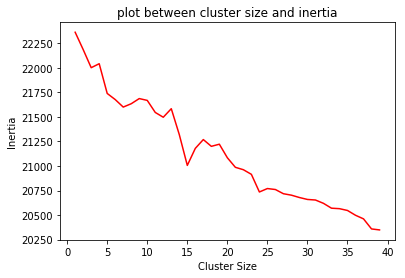

In [14]:
#Plot between cluster size and inertia
plt.plot(n_clusters, vec_inertia, color='red')
plt.title('plot between cluster size and inertia')
plt.xlabel('Cluster Size')
plt.ylabel('Inertia')
plt.show()

In [10]:
kmeans = KMeans(n_clusters=24, random_state=0, n_init=3, max_iter=100).fit(X_vec)
print("Inter cluster distance in final clustering", kmeans.inertia_)

Inter cluster distance in final clustering 20735.363911499953


Word Cloud for cluster 0


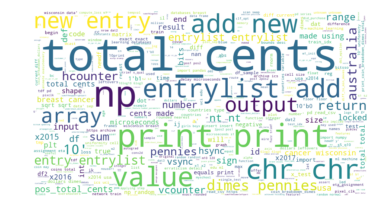

Word Cloud for cluster 1


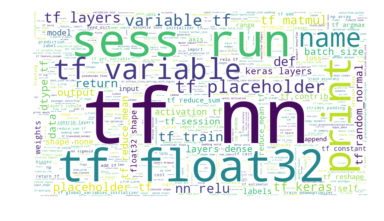

Word Cloud for cluster 2


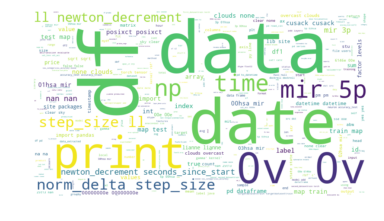

Word Cloud for cluster 3


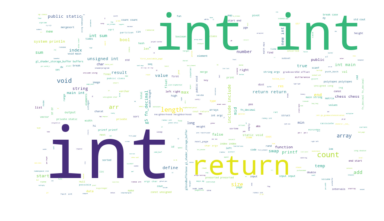

Word Cloud for cluster 4


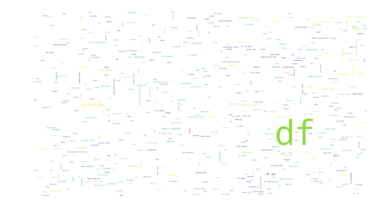

Word Cloud for cluster 5


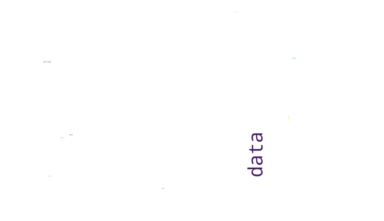

Word Cloud for cluster 6


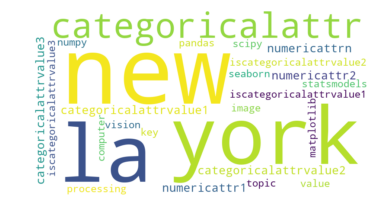

Word Cloud for cluster 7


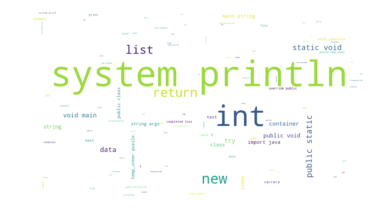

Word Cloud for cluster 8


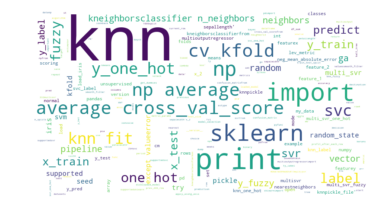

Word Cloud for cluster 9


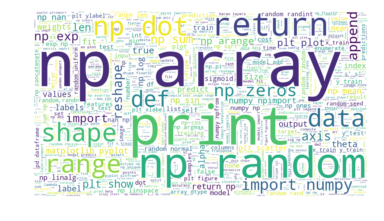

Word Cloud for cluster 10


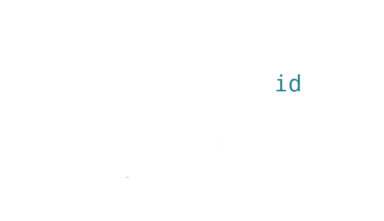

Word Cloud for cluster 11


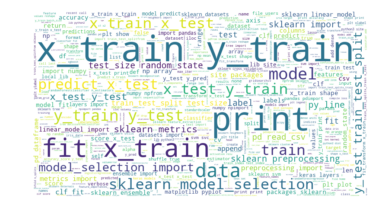

Word Cloud for cluster 12


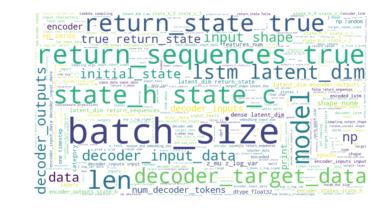

Word Cloud for cluster 13


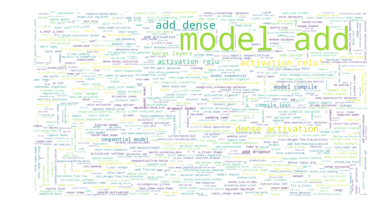

Word Cloud for cluster 14


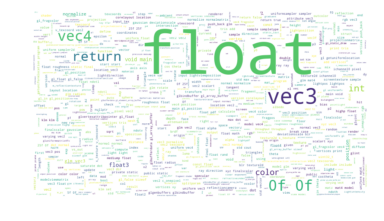

Word Cloud for cluster 15


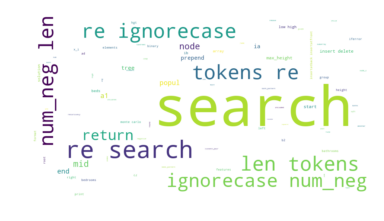

Word Cloud for cluster 16


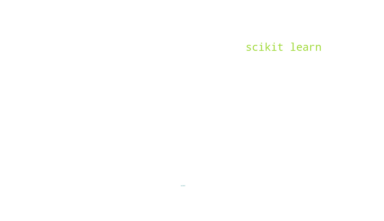

Word Cloud for cluster 17


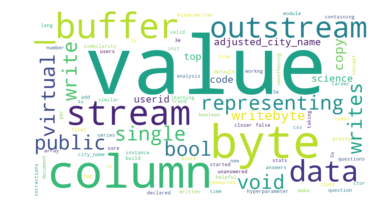

Word Cloud for cluster 18


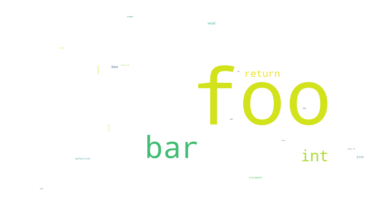

Word Cloud for cluster 19


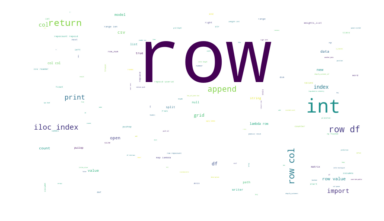

Word Cloud for cluster 20


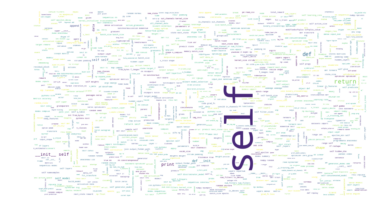

Word Cloud for cluster 21


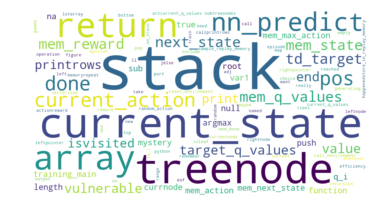

Word Cloud for cluster 22


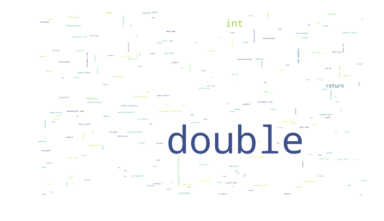

Word Cloud for cluster 23


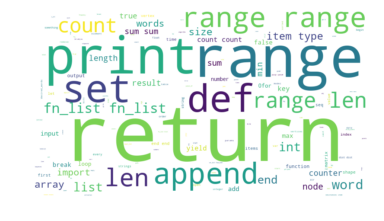

In [14]:
total_code_list = np.array(total_code_list)
for i in range(0,24):
    print("Word Cloud for cluster", i)
    from wordcloud import WordCloud
    wc = WordCloud(background_color ='white',width=900,height=500, max_words=1628,relative_scaling=1,
                   normalize_plurals=False).generate(str(total_code_list[kmeans.labels_ == i]))

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('Cluster_Images/cluster'+str(i)+'.png')
    plt.show()

In [11]:
code_cluster_list = []
count = 0
for i in range(text.shape[0]):
    cluster_array = np.zeros(25)
    if i in code_dict:
        cluster_array[kmeans.labels_[count]] = 1
        count = count + 1
    else:
        cluster_array[24] = 1
    code_cluster_list.append(cluster_array)

In [12]:
code_cluster_list[0:5]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.])]

<h3> 3. Does_site_the_same_link </h3>

<p> Similar to programming code, URL is also one such feature that require special featurization.Since URL too has 
a special structure, normal data processing treatment will make it lose its meaning. URLs can be feature engineered 
seperately by finding if two posts cites the same url or not, if so then may be both refers to the similar thing.
</p>
<p>
On analysis, we could find that nearly 31% of the urls cited are repeated ones.Hence there is a descent probability
that cites will be repeat and that can be used to find similar posts
</p>

In [13]:
all_links = []
posts_links = {}
for i in range(text.shape[0]):
    httplinkpattern = re.compile('http:.*?"')
    httpslinkpattern = re.compile('https:.*?"')
    removecomma = re.compile('"$')
    http_list = httplinkpattern.findall(text[i])
    https_list = httpslinkpattern.findall(text[i])
    total_link = http_list + https_list
    for i in range(len(total_link)):
        total_link[i] = re.sub(removecomma, '', total_link[i])
    all_links = all_links + total_link
    posts_links[i] = total_link

In [14]:
print("Total number of links:", len(all_links))
print("Total number of unique links", len(set(all_links)))

Total number of links: 109029
Total number of unique links 75430


In [15]:
def get_cites_similarity(i, j):
    if i not in posts_links or j not in posts_links:
        return None
    count_similar_cites = 0
    for each_link_i in posts_links[i]:
        for each_link_j in posts_links[j]:
            if each_link_i == each_link_j:
                count_similar_cites = count_similar_cites+1
    return count_similar_cites

<h2> 3. Document Embedding </h2>

<p>
Document Embedding is one of the most important and critical step of the posts text. It involves converting the
text representation of the posts data into a numerical vector space. Effectiveness of the search engine
very much depends on this part.
</p>
<h6> Four different types of embedding techniques is used here </h6>
<p> They are: <br>
1) Simple average word2Vec <br>
2) Keyword Extraction + Simple Average word2Vec <br>
3) TF-IDF Weighted word2Vec <br>
4) Keyword Extraction + TF-IDF Weighted word2Vec <br> 
</p>

In [2]:
total_df = pd.read_pickle("Preprocessed_questions_text.pkl")

In [3]:
print("Shape", total_df.shape)
total_df.head(5)

Shape (128784, 6)


,Id,Text,Topic,non_stopword_removed_preprocessed_text_x,non_stopword_removed_preprocessed_text_y,preprocessed_text
0,89504,<p>I've always been interested in machine lear...,DataScience,i have always been interested in machine lear...,i have always been interested in machine lear...,always interested machine learning figure one ...
1,89505,"<p>As a researcher and instructor, I'm looking...",DataScience,as a researcher and instructor i am looking f...,as a researcher and instructor i am looking f...,researcher instructor looking opensource books...
2,89506,"<p>Not sure if this fits the scope of this SE,...",DataScience,not sure if this fits the scope of this se bu...,not sure if this fits the scope of this se bu...,sure fits scope se stab answer anyway ai appro...
3,89507,"<p>One book that's freely available is ""The El...",DataScience,one book that is freely available is the elem...,one book that is freely available is the elem...,one book freely available elements statistical...
4,89508,<p>I am sure data science as will be discussed...,DataScience,i am sure data science as will be discussed i...,i am sure data science as will be discussed i...,sure data science discussed forum several syno...


In [4]:
preprocessed_text = total_df['preprocessed_text']
print("preprocessed_text", preprocessed_text.shape)

preprocessed_text (128784,)


In [5]:
preprocessed_text[0]

'always interested machine learning figure one thing starting simple hello world example avoid hardcoding behavior example wanted teach bot avoid randomly placed obstacles could use relative motion obstacles move around want hard code say distance ruins whole point machine learning obviously randomly generating code would impractical could '

<h3> 2.1) Technique 1: Simple Word2Vec Vectorization </h3>

<h3> 2.1.1) Glove Vectors </h3>

In [35]:
import spacy
import en_core_web_sm
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = en_core_web_sm.load()
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
def avg_weighted_vector(list_of_sent):
    vecs = []
    i = 0
    for qu in tqdm(list(list_of_sent)):
        doc = nlp(qu) 
        # 384 is the number of dimensions of vectors 
        mean_vec = np.zeros([len(doc), len(doc[0].vector)])
        for word in doc:
            # word2vec
            vec = word.vector
            # fetch df score
            mean_vec += vec 
        mean_vec = mean_vec.mean(axis=0)
        vecs.append(mean_vec)
        i = i +1
    return vecs

In [36]:
avgweighted_w2vec = avg_weighted_vector(preprocessed_text)

100%|██████████| 128784/128784 [50:20<00:00, 33.04it/s] 


In [37]:
pd.DataFrame(avgweighted_w2vec).to_csv('glove_vectors.csv')

<h3>  2.1.2) TF-IDF weighted Word2vec </h3>

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(lowercase=False, min_df=10)
tfidf = tfidf.fit(preprocessed_text)
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [40]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = en_core_web_sm.load()
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
def tfidf_weighted_vector(list_of_sent):
    vecs = []
    i = 0
    for qu in tqdm(list(list_of_sent)):
        doc = nlp(qu) 
        # 384 is the number of dimensions of vectors 
        mean_vec = np.zeros([len(doc), len(doc[0].vector)])
        for word in doc:
            # word2vec
            vec = word.vector
            # fetch df score
            try:
                idf = word2tfidf[str(word)]
                print
            except:
                idf = 0
            # compute final vec
            mean_vec += vec * idf
        mean_vec = mean_vec.mean(axis=0)
        vecs.append(mean_vec)
        i = i +1
    return vecs

In [41]:
tfidf_weighted_glove_vector = tfidf_weighted_vector(preprocessed_text)

100%|██████████| 128784/128784 [50:21<00:00, 42.62it/s] 


In [42]:
pd.DataFrame(tfidf_weighted_glove_vector).to_csv('tfidfweighted_glove_vectors.csv')

<h3> 2.2) Technique 2: Keyword Extraction + Word2Vec Vectorization </h3>

<p>
YAKE - Yet Another Keyword Extractor is one of the nice approaches for extracting keywords from the text.
It has proved to outperform a number of unsupervised methods and a supervised method under a number of 
collections of different sizes, languages or domains. <br>
Hence it is used to extract the keywords in each of the posts text first and then apply embeddings to it
</p>

In [43]:
def tokenization(keywords_text):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(keywords_text)

In [44]:
simple_kwextractor = yake.KeywordExtractor()
questions_keywords_text = []
for i in range(preprocessed_text.shape[0]):
    if i%10 == 0:
        print(i,"vectors finished")
    keyword_simple = simple_kwextractor.extract_keywords(preprocessed_text[i])
    keyword_text = ""
    for each_kw in keyword_simple:
        keyword_text += each_kw[0] + " "
    questions_keywords_text.append(set(tokenization(keyword_text)))
questions_keywords_sets = np.array(questions_keywords_text)

In [45]:
pd.DataFrame(questions_keywords_text).to_pickle('keywords.pkl')

In [46]:
questions_keywords_sets[0]

{'avoid',
 'behavior',
 'bot',
 'code',
 'example',
 'figure',
 'generating',
 'hardcoding',
 'hello',
 'interested',
 'learning',
 'machine',
 'motion',
 'move',
 'obstacles',
 'one',
 'point',
 'randomly',
 'relative',
 'simple',
 'starting',
 'teach',
 'thing',
 'wanted',
 'world'}

In [6]:
df = pd.read_pickle('keywords.pkl')
questions_keywords_sets = []
for i in range(df.shape[0]):
    res = []
    for val in df.values[i]: 
        if val != None : 
            res.append(val) 
    questions_keywords_sets.append(res)

In [7]:
preprocessed_text_keywords = []
for i in range(len(questions_keywords_sets)):
    keyword_text = ""
    for each_keyword in questions_keywords_sets[i]:
        keyword_text += each_keyword + " "
    preprocessed_text_keywords.append(keyword_text)

In [8]:
len(preprocessed_text_keywords)

128784

In [9]:
preprocessed_text_keywords_df = pd.DataFrame(preprocessed_text_keywords, columns=['preprocessed_text_keywords'])
preprocessed_text_keywords_df.index = total_df.index
preprocessed_text_keywords_df['Id'] = total_df['Id']
total_df = total_df.merge(preprocessed_text_keywords_df, on='Id',how='left')

In [10]:
total_df.to_pickle('Preprocessed_keyword_text.pkl')

<h3> 2.2.1) Keyword Extraction + Glove vectors </h3>

In [11]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
def avg_weighted_keyword_vector(list_of_sent):
    vecs = []
    i = 0
    for qu in tqdm(list(list_of_sent)):
        doc = nlp(qu)
        if(len(doc) == 0):
            doc = nlp(preprocessed_text[i])
        mean_vec = np.zeros([len(doc), len(doc[0].vector)])
        for word in doc:
            # word2vec
            vec = word.vector
            # fetch df score
            mean_vec += vec 
        mean_vec = mean_vec.mean(axis=0)
        vecs.append(mean_vec)
        i = i +1
    return vecs

In [12]:
preprocessed_text_keywords_vector = avg_weighted_keyword_vector(preprocessed_text_keywords)

100%|██████████| 128784/128784 [22:15<00:00, 96.43it/s] 


In [13]:
pd.DataFrame(preprocessed_text_keywords_vector).to_csv('avgw2v_keywords_vector.csv')

<h3> 2.2.2) Keyword Extraction + TF-IDF Weighted Glove vectors </h3>

In [14]:
nlp = en_core_web_sm.load()
def avg_weighted_keyword_vector(list_of_sent):
    vecs = []
    i = 0
    for qu in tqdm(list(list_of_sent)):
        doc = nlp(qu)
        if(len(doc) == 0):
            doc = nlp(preprocessed_text[i])
        mean_vec = np.zeros([len(doc), len(doc[0].vector)])
        for word in doc:
            # word2vec
            vec = word.vector
            # fetch df score
            try:
                idf = word2tfidf[str(word)]
                print
            except:
                idf = 0
            mean_vec += vec * idf
        mean_vec = mean_vec.mean(axis=0)
        vecs.append(mean_vec)
        i = i +1
    return vecs

In [15]:
tfidfweighted_keyword_vectors = avg_weighted_keyword_vector(preprocessed_text_keywords)

100%|██████████| 128784/128784 [22:26<00:00, 95.63it/s] 


In [16]:
pd.DataFrame(preprocessed_text_keywords_vector).to_csv('tfidfweightedw2v_keywords_vector.csv')

<h2> Simple Search Engine </h2>

<p>
A simple search engine code is written which aims make use of the power of multiprocessing. Since there are 1.2L
posts, we could divide it each into 40K and then process by spanning 4 parallel process.Each process try to
find the similarity between the given test query point and the chunk of data.It then updates the values in the 
top_k_similar_docs list which will always contain top 10 similar posts for the given test query post.
We perform a insertion sort like insertion to acheive this.Latency due to the update of top_k_similar_docs list
could furthur be reduced by queuing a celery task which will be a seperate task to update the top_k_similar_docs
with the given value and not interrupting the similarity finding process execution.Since python list is thread safe, 
multiple updates don't lead to racing condition.By this low latency could be acheived and the process will
be completed in less time.But it took somewhat 30-40 secs may be because of the insertion for every docs similarity
</p>

<p>
    Hence an more efficient map-reduce like solution is implemented where 8 processes are spawn to run independently
and each processes returns an 10 length list which the top 10 highest similarity of the docs computed in that range.
Then all the 10 length list returned by all the processes are combined together and sorted to get the total
top 10 similarity.A simple map reduce like technique enabled the latency to be within 20 secs
</p>

In [16]:
vec_sim_list = []
k = 10

In [18]:
import multiprocessing
alpha = 0.001

def get_topic_similarity(ind1, ind2):
    dist = euclidean_distances(topics[ind1], topics[ind2])[0][0]
    if dist == 0:
        return 1/(dist+alpha)
    else:
        return dist

def get_code_similarity(ind1, ind2):
    dist = euclidean_distances(code_cluster_list[ind1].reshape(-1, 1), 
                                 code_cluster_list[ind2].reshape(-1, 1))[0][0]
    if dist == 0:
        return 1/(dist+alpha)
    return dist
       
def insert_into_top_k_similar_docs(top_k_similar_docs, vec_similarity, doc_id):
    doc_dict = dict()
    doc_dict["doc_id"] = doc_id
    doc_dict["similarity"] = vec_similarity
    should_insert = False
    #print("len", len(top_k_similar_docs))
    for i in range(11):
        #print("it 1", i)
        if i == 10:
            return
        if vec_similarity > top_k_similar_docs[i]['similarity']:
            should_insert = True
            break
    #print("i", i)
    if should_insert:
        docs_place = i
        temp_list = []
        for i in range(docs_place, k-1):
            #print("it 2", i)
            temp_list.append(top_k_similar_docs[i])
        ind = 0
        for i in range(docs_place+1 , k):
            top_k_similar_docs[i] = temp_list[ind]
            ind = ind + 1
        top_k_similar_docs[docs_place] = doc_dict
    #print("top_k_similar_docs", top_k_similar_docs)
        
def find_vector_similarity(preprocessed_text_vector, test_query_point, start, end, topic_weight=1, code_weight=1,
                          cites_weight=1):
    #print("In find_vector_distance")
    #print("start", start)
    #print("end", end)
    top_k_similar_docs = []
    for i in range(10):
        doc_dict = dict()
        doc_dict['doc_id'] = 0
        doc_dict['similarity'] = -1
        top_k_similar_docs.append(doc_dict)
    #print("top_k_similar_docs", top_k_similar_docs)
        
    for i in range(start, end):
        if i >= preprocessed_text_vector.shape[0]:
            return
        vec_similarity = cosine_similarity(preprocessed_text_vector[i].reshape(1,-1), 
                                           preprocessed_text_vector[test_query_point].reshape(1,-1))[0][0]
        #print("vec_similarity", vec_similarity)
        topicwise_similarity = get_topic_similarity(i, test_query_point)* topic_weight
        #print("topicwise_similarity", topicwise_similarity)
        codewise_similarity = get_code_similarity(i, test_query_point) * code_weight
        #print("codewise_similarity", codewise_similarity)
        cites_similarity = get_cites_similarity(i, test_query_point)
        #print("cites_similarity", cites_similarity)
        if cites_similarity:
            cites_similarity = cites_similarity * cites_weight
            #print("cites_similarity weight", cites_similarity)
            vec_similarity = vec_similarity + topicwise_similarity + codewise_similarity + cites_similarity
        else:
            vec_similarity = vec_similarity + topicwise_similarity + codewise_similarity
        vec_sim_list.append(vec_similarity)
        #print("vec_similarity", vec_similarity)
        insert_into_top_k_similar_docs(top_k_similar_docs, vec_similarity, i)  
    #print("top_k_similar_docs on return", top_k_similar_docs)
    return top_k_similar_docs

In [19]:
# This function takes last element as pivot, places 
# the pivot element at its correct position in sorted 
# array, and places all smaller (smaller than pivot) 
# to left of pivot and all greater elements to right 
# of pivot 
def partition(arr,low,high): 
    i = ( low-1 )         # index of smaller element 
    pivot = arr[high]     # pivot 
  
    for j in range(low , high): 
  
        # If current element is smaller than or 
        # equal to pivot 
        if   arr[j] <= pivot: 
          
            # increment index of smaller element 
            i = i+1 
            arr[i],arr[j] = arr[j],arr[i] 
  
    arr[i+1],arr[high] = arr[high],arr[i+1] 
    return ( i+1 ) 
  
# The main function that implements QuickSort 
# arr[] --> Array to be sorted, 
# low  --> Starting index, 
# high  --> Ending index 
  
# Function to do Quick sort 
def quickSort(arr,low,high): 
    if low < high: 
  
        # pi is partitioning index, arr[p] is now 
        # at right place 
        pi = partition(arr,low,high) 
  
        # Separately sort elements before 
        # partition and after partition 
        quickSort(arr, low, pi-1) 
        quickSort(arr, pi+1, high) 

In [20]:
def humanize_seconds(seconds, max_units=2):
    periods = [
        ('day',         60*60*24),
        ('hour',        60*60),
        ('min',      60),
        ('sec',      1)
    ]

    strings=[]
    current_units = 0
    for period_name, period_seconds in periods:
        current_units += 1
        if seconds >= period_seconds:
            period_value , seconds = divmod(seconds, period_seconds)
            has_s = 's' if period_value != 1 else ''
            if len(strings)>=max_units-1:
                if seconds and seconds>=periods[current_units-1][1]/2:
                    period_value += 1
                has_s = 's' if period_value !=1 else ''
                strings.append("%s %s%s" % (period_value, period_name, has_s))
                break

            strings.append("%s %s%s" % (period_value, period_name, has_s))

    return ", ".join(strings)

In [43]:
def simple_search_engine(preprocessed_text_vector, test_sample, topic_weight=1, code_weight=1, cites_weight=1):
    #print("top_k_similar_docs", top_k_similar_docs)
    count = 0
    posts_text = pd.read_pickle('Preprocessed_questions_text.pkl')['Text'].values
    #print("test_sample", test_sample)
    for each_test_point in test_sample:
        list_of_top_k_docs = [] 
        start_time = datetime.now()
        #print(each_test_point)
        #print("top_k_similar_docs", top_k_similar_docs)
        vec_sim_list = []
        test_query_point = preprocessed_text_vector[each_test_point]
        print("Query posts",each_test_point, ":" , posts_text[each_test_point])
        print("#"*100)
        start = 0
        step = 16100
        input_list = []
        while start < preprocessed_text_vector.shape[0]:      
            input_list.append([preprocessed_text_vector, each_test_point, start, start+step, 
                               topic_weight, code_weight, cites_weight ])
            start = start+step
        #print("input_list", input_list)
        pool = multiprocessing.Pool(processes=4)
        tasks=[]
        for each in input_list:
            tasks.append(pool.apply_async(find_vector_similarity,each))
        pool.close()
        pool.join()
        for each in tasks:
            each.wait()
            result = each.get()
            list_of_top_k_docs.extend(result)
        quickSort(list_of_top_k_docs, 0, len(list_of_top_k_docs))
        list_of_top_k_docs = list_of_top_k_docs[0:10]
        total_time = (datetime.now() - start_time).total_seconds()
        print("Total time taken:", humanize_seconds(total_time))
        print("The Most similar ",k,"posts are:")
        for each in list_of_top_k_docs:
            print(posts_text[each['doc_id']])
            print("#"*100)
        print("*"*200)

<h2> Final Results </h2>

In [22]:
total_df = pd.read_pickle("Preprocessed_questions_text.pkl")
posts_text = total_df['Text']
test_sample = []
test_sample.append(52671)
test_sample.append(2286)
for each in test_sample:
    print("Posts:")
    print(posts_text[each])
    print("#"*100)

Posts:
<p>Hint: Hamiltonian Cycle is $NP$-Complete.</p>

####################################################################################################
Posts:
<p>In Support Vector Machines, when used for sentiment analysis, text gets converted into a set of data points. How does this happen, usually?</p>

####################################################################################################


In [23]:
test_sample

[52671, 2286]

<h3> Simple Word2Vec Vectors </h3>

In [24]:
preprocessed_text_vector = pd.read_csv('glove_vectors.csv').values
print("vector shape", preprocessed_text_vector.shape)

vector shape (128784, 97)


In [25]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
simple_search_engine(preprocessed_text_vector, test_sample)

Query posts 52671 : <p>Hint: Hamiltonian Cycle is $NP$-Complete.</p>

####################################################################################################
Total time taken: 20.0 secs
The Most similar  10 posts are:
<p>Hint: Hamiltonian Cycle is $NP$-Complete.</p>

####################################################################################################
<p>Hint: This is just the well-known NP-complete problem PARTITION.</p>

####################################################################################################
<p>Is there a notion of a context-free complete language (in the analogous sense to a <span class="math-container">$NP$</span>-complete language)?</p>

####################################################################################################
<p>For example;</p>

<p>Is {0,1,{a,b,c},d,e} a valid alphabet to form a language over and is it usable in any context?</p>

###################################################################

In [33]:
top_k_similar_docs

[{'doc_id': 2286, 'similarity': 2001.0},
 {'doc_id': 12797, 'similarity': 2000.9996701750035},
 {'doc_id': 17964, 'similarity': 2000.9995700601494},
 {'doc_id': 16972, 'similarity': 2000.9995578766902},
 {'doc_id': 9865, 'similarity': 2000.9995387067127},
 {'doc_id': 9756, 'similarity': 2000.999521210254},
 {'doc_id': 11409, 'similarity': 2000.9995086905162},
 {'doc_id': 26152, 'similarity': 2000.9995035967393},
 {'doc_id': 16082, 'similarity': 2000.9994953168857},
 {'doc_id': 6737, 'similarity': 2000.9994912397292}]

<h3> Keyword Extracted Word2Vec Vectors  </h3>

In [34]:
keywordw2vec_preprocessed_text_vector = pd.read_csv('avgw2v_keywords_vector.csv')
print("vector shape", keywordw2vec_preprocessed_text_vector.shape)

vector shape (128784, 97)


In [36]:
simple_search_engine(keywordw2vec_preprocessed_text_vector.values, test_sample, 
                     topic_weight=3, code_weight=3, cites_weight=3)

Query posts 52671 : <p>Hint: Hamiltonian Cycle is $NP$-Complete.</p>

####################################################################################################
Total time taken: 19.0 secs
The Most similar  10 posts are:
<p>Hint: Hamiltonian Cycle is $NP$-Complete.</p>

####################################################################################################
<p>Is there a notion of a context-free complete language (in the analogous sense to a <span class="math-container">$NP$</span>-complete language)?</p>

####################################################################################################
<p>Does it exist an algorithm to find a median of table with a complexity nlog(n) 
Thank</p>

####################################################################################################
<p>2^n=O(3^n) : This is true or it is false if n>=0 or if n>=1
since 2^n may or not be element of O(3^n)
I need a hint to figure the problem</p>

########################

In [37]:
top_k_similar_docs

[{'doc_id': 2286, 'similarity': 2001.0},
 {'doc_id': 6495, 'similarity': 2000.9996120083458},
 {'doc_id': 7297, 'similarity': 2000.9995960540978},
 {'doc_id': 3269, 'similarity': 2000.9995720464228},
 {'doc_id': 3712, 'similarity': 2000.9995709783898},
 {'doc_id': 3431, 'similarity': 2000.9995327981526},
 {'doc_id': 3445, 'similarity': 2000.999530539103},
 {'doc_id': 7147, 'similarity': 2000.9995294615755},
 {'doc_id': 2769, 'similarity': 2000.9995232865747},
 {'doc_id': 4935, 'similarity': 2000.999520751479}]

<h3> TF-IDF Weighted Word2Vec Vectors </h3>

In [38]:
tfidfweightedw2v_preprocessed_text_vector = pd.read_csv('tfidfweighted_glove_vectors.csv')
print("vector shape", tfidfweightedw2v_preprocessed_text_vector.shape)

vector shape (128784, 97)


In [40]:
simple_search_engine(tfidfweightedw2v_preprocessed_text_vector.values, test_sample)

Query posts 52671 : <p>Hint: Hamiltonian Cycle is $NP$-Complete.</p>

####################################################################################################
Total time taken: 19.5 secs
The Most similar  10 posts are:
<p>Hint: Hamiltonian Cycle is $NP$-Complete.</p>

####################################################################################################
<p>Hint: This is just the well-known NP-complete problem PARTITION.</p>

####################################################################################################
<p>Is there a notion of a context-free complete language (in the analogous sense to a <span class="math-container">$NP$</span>-complete language)?</p>

####################################################################################################
<p>Can an ambiguous context-free grammar be converted into Chomsky normal form? I think the answer is yes.</p>

###############################################################################

In [41]:
top_k_similar_docs

[{'doc_id': 2286, 'similarity': 2001.0},
 {'doc_id': 17964, 'similarity': 2000.992590378181},
 {'doc_id': 10607, 'similarity': 2000.9913787988119},
 {'doc_id': 17117, 'similarity': 2000.9913291167177},
 {'doc_id': 26152, 'similarity': 2000.9913267404502},
 {'doc_id': 17261, 'similarity': 2000.9911955589764},
 {'doc_id': 39259, 'similarity': 2000.991166129822},
 {'doc_id': 35011, 'similarity': 2000.9909182253195},
 {'doc_id': 30357, 'similarity': 2000.9908323743557},
 {'doc_id': 9700, 'similarity': 2000.990686181261}]

<h3> Keyword Extracted TF-IDF Weighted Word2Vec Vectors </h3>

In [42]:
keywordtfidfw2v_preprocessed_text_vector = pd.read_csv('tfidfweightedw2v_keywords_vector.csv')
print("vector shape", keywordtfidfw2v_preprocessed_text_vector.shape)

vector shape (128784, 97)


In [44]:
simple_search_engine(keywordtfidfw2v_preprocessed_text_vector.values, test_sample)

Query posts 52671 : <p>Hint: Hamiltonian Cycle is $NP$-Complete.</p>

####################################################################################################
Total time taken: 20.0 secs
The Most similar  10 posts are:
<p>Hint: Hamiltonian Cycle is $NP$-Complete.</p>

####################################################################################################
<p>Is there a notion of a context-free complete language (in the analogous sense to a <span class="math-container">$NP$</span>-complete language)?</p>

####################################################################################################
<p>Does it exist an algorithm to find a median of table with a complexity nlog(n) 
Thank</p>

####################################################################################################
<p>2^n=O(3^n) : This is true or it is false if n>=0 or if n>=1
since 2^n may or not be element of O(3^n)
I need a hint to figure the problem</p>

########################

In [45]:
top_k_similar_docs

[{'doc_id': 2286, 'similarity': 2001.0},
 {'doc_id': 6495, 'similarity': 2000.9996120083458},
 {'doc_id': 7297, 'similarity': 2000.9995960540978},
 {'doc_id': 3269, 'similarity': 2000.9995720464228},
 {'doc_id': 3712, 'similarity': 2000.9995709783898},
 {'doc_id': 3431, 'similarity': 2000.9995327981526},
 {'doc_id': 3445, 'similarity': 2000.999530539103},
 {'doc_id': 7147, 'similarity': 2000.9995294615755},
 {'doc_id': 2769, 'similarity': 2000.9995232865747},
 {'doc_id': 4935, 'similarity': 2000.999520751479}]

<h5> Final Analysis </h5>
<p>
1) In similar posts prediction using glove vectors, for the first posts which is of about genetic algorithm, we 
could observe some of the similar predictions regarding like neural network, CNN which are also algorithm
based on human organs behaviour and learning.some posts related to algorithm and ml since the presence of
those in the query posts.For second posts on word embedding based on neural network, it predicted similar posts
on neural network and LSTMs
</p>
<p>
2) keyword extracted word2vec also does a pretty descent task as it finds more posts related to ml.In the way for 
the encoding, it finds posts related to categorical variable encoding and neural nets
</p>
<p>
3) We could also observe tf-idf weighted glove vectors does almost the same job in terms of the prediction.Hence
tf-idf values doesnt add any impact to improve the prediction performance
</p>